# Japanese Restaurants in different New York City neighborhoods

### Import all required libraries

In [ ]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests # library to handle requests

!pip install BeautifulSoup4
import os

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

import seaborn as sns

In [2]:
print('Libraries imported.')

Libraries imported.


### Define Foursquare credentials & Version

In [ ]:
# Define Foursquare Credentials and Version

CLIENT_ID = '################################################' # Foursquare ID
CLIENT_SECRET = '################################################' # Foursquare Secret
LIMIT = 40
VERSION = '########'
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

## Define functions to be used later 

In [4]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

### Analyze number and type of neighborhoods in New York City

In [5]:
ny_data = get_new_york_data()
ny_data.head() #Top 5 neighborhoods

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [6]:
ny_data = get_new_york_data()
ny_data.tail() # Bottom 5 neighborhoods

,Borough,Neighborhood,Latitude,Longitude
301,Manhattan,Hudson Yards,40.756658,-74.000111
302,Queens,Hammels,40.587338,-73.805530
303,Queens,Bayswater,40.611322,-73.765968
304,Queens,Queensbridge,40.756091,-73.945631
305,Staten Island,Fox Hills,40.617311,-74.081740


In [7]:
ny_data.shape 

(306, 4)

So, there a total of 306 neighborhoods in New York City

## Visualize Initial Data Analysis

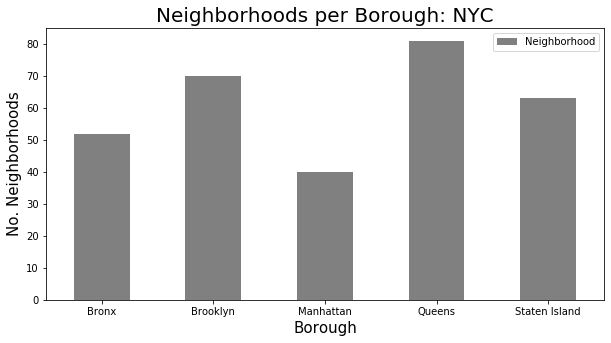

In [8]:
clr = "gray"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

Queens has the most number of neighborhoods and Manhattan the least

In [9]:
# prepare neighborhood list that contains japanese restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
japanese_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    japanese_restaurants=venues[venues['Category']=='Japanese Restaurant']   
    print('(',count,'/',len(ny_data),')','Japanese Restaurants in '+Neighborhood+', '+Borough+':'+str(len(japanese_restaurants)))
    print(row)
    for resturant_detail in japanese_restaurants.values.tolist():
        id, name , category=resturant_detail
        japanese_rest_ny = japanese_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Japanese Restaurants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Japanese Restaurants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Japanese Restaurants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Japanese Restaurants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Japanese Restaurants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Japanese Restaurants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Japanese Restaurants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Japanese Restaurants in Woodlawn, Bronx:0
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Japanese Restaurants in Norwood, B

In [10]:
#japanese_rest_ny.to_csv('japanese_rest_ny_tocsv1.csv') # Save the information so far to a .csv file due to limited calls on FourSquare
japanese_rest_ny.to_csv('japanese_rest_ny_tocsv1.csv')

In [11]:
japanese_ny = pd.read_csv('japanese_rest_ny_tocsv1.csv')
japanese_rest_ny.tail()

,Borough,Neighborhood,ID,Name
58,Manhattan,Flatiron,581a10901df6b32e66ec3a07,Sugarfish
59,Manhattan,Flatiron,5bd7a5561c675b0039be9acc,HALL
60,Manhattan,Flatiron,55805bb5498e8356d675aa22,Yakiniku Futago
61,Queens,Sunnyside Gardens,4ba2a9cbf964a520d00d38e3,Oki Japanese Restaurant
62,Brooklyn,Fulton Ferry,5cf1562460255e002c5e683c,Bessou


In [12]:
japanese_rest_ny.shape

(63, 4)

There are 63 Japanese restaurants across all Boroughs

### Let's visualize these restaurants per borough and neighborhood

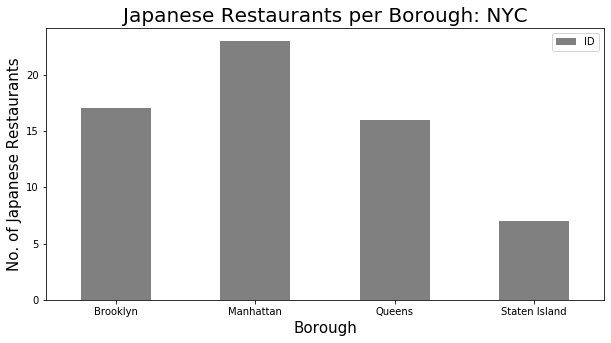

In [13]:
japanese_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Japanese Restaurants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. of Japanese Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

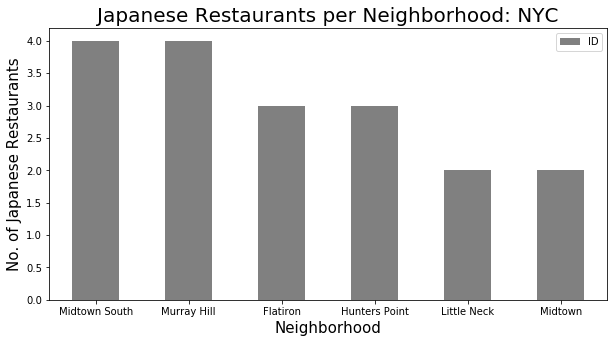

In [14]:
NOofNeigh = 6 # top number for graphing all the same past 6
japanese_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color=clr)
plt.title('Japanese Restaurants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('No. of Japanese Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

Midtown South and Murray Hill have the maximum number of restaurants per neighborhood.

### Let's check what these restauants are in Murray Hill

In [15]:
japanese_rest_ny[japanese_rest_ny['Neighborhood']=='Murray Hill']

,Borough,Neighborhood,ID,Name
20,Manhattan,Murray Hill,4a99b4f4f964a520f62f20e3,Kajitsu
21,Manhattan,Murray Hill,591caee89deb7d0f69be77a2,Omusubi Gonbei
22,Manhattan,Murray Hill,540dc46d498e86f0e5059dd2,Zuma New York
36,Queens,Murray Hill,4bc8eee83740b713fcbe5d65,Northern Sushi


### Next determine the ratings, tips and likes of these restaurants from Foursquare

In [16]:
#Japanese restaurants with Ratings in the neighborhood
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
japanese_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in japanese_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(japanese_rest_ny),')','processed')
    japanese_rest_stats_ny = japanese_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    if count==50:
        print('Details collected for 50 restaurants')
        break #As the number of Foursquare API calls are limited to 50 premium calls/day, we restrict data to 50 restaurants
    count+=1

{'meta': {'code': 200, 'requestId': '5f2fa4f72002af58d50b7b09'}, 'response': {'venue': {'id': '4d5c12a01e43236a87eb1583', 'name': 'Sake Sushi', 'contact': {'phone': '7188515299', 'formattedPhone': '(718) 851-5299'}, 'location': {'address': '328 Church Ave', 'crossStreet': 'East 4th Street', 'lat': 40.644138, 'lng': -73.976439, 'labeledLatLngs': [{'label': 'display', 'lat': 40.644138, 'lng': -73.976439}], 'postalCode': '11218', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['328 Church Ave (East 4th Street)', 'Brooklyn, NY 11218', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sake-sushi/4d5c12a01e43236a87eb1583', 'categories': [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 49}, 'url': 'http

In [17]:
print('Details collected for 50 restaurants')

Details collected for 50 restaurants


In [18]:
japanese_rest_stats_ny.tail()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
45,Staten Island,Charleston,4bc898de15a7ef3b40697bda,Buddha Lounge,11,5.8,14
46,Staten Island,Bulls Head,4b79eec8f964a520161b2fe3,Sapporo Sushi,15,6.8,13
47,Manhattan,Midtown South,51e8ce40498ea1fb0180efb2,Izakaya MEW,1054,8.8,266
48,Manhattan,Midtown South,57ab615d498eef084faa348b,Abiko Curry,132,8.3,28
49,Manhattan,Midtown South,5d7a9d59a369d40008dfcc1a,Konbini,16,8.3,2


In [19]:
japanese_rest_stats_ny.to_csv('japanese_rest_stats_ny_csv.csv') # save data to a .csv file

In [20]:
japanese_rest_stats_ny.shape

(50, 7)

We can see that data for only 50 restaurants are stored

In [21]:
japanese_rest_stats_ny.info() #To determine the type in which the data are stored

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
Borough         50 non-null object
Neighborhood    50 non-null object
ID              50 non-null object
Name            50 non-null object
Likes           50 non-null object
Rating          50 non-null float64
Tips            50 non-null object
dtypes: float64(1), object(6)
memory usage: 2.8+ KB


Tips and likes are considered as string values here. They have to be converted to float type

In [22]:
japanese_rest_stats_ny['Likes'] = japanese_rest_stats_ny['Likes'].astype('float64')
japanese_rest_stats_ny['Tips'] = japanese_rest_stats_ny['Tips'].astype('float64')
japanese_rest_stats_ny.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
Borough         50 non-null object
Neighborhood    50 non-null object
ID              50 non-null object
Name            50 non-null object
Likes           50 non-null float64
Rating          50 non-null float64
Tips            50 non-null float64
dtypes: float64(3), object(4)
memory usage: 2.8+ KB


We can see that Likes and Tip have been converted to float type now

In [23]:
japanese_rest_stats_ny.describe() #Let's calculate the average rating, tips and likes

,Likes,Rating,Tips
count,50.000000,50.000000,50.00000
mean,135.900000,7.356000,40.98000
std,222.344764,2.320904,60.13946
min,0.000000,0.000000,0.00000
25%,13.250000,7.275000,5.00000
50%,38.000000,8.200000,14.50000
75%,173.000000,8.550000,58.75000
max,1054.000000,9.200000,266.00000


In [24]:
# Resturant with maximum Likes
japanese_rest_stats_ny.iloc[japanese_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood               Midtown South
ID              51e8ce40498ea1fb0180efb2
Name                         Izakaya MEW
Likes                               1054
Rating                               8.8
Tips                                 266
Name: 47, dtype: object

In [25]:
# Resturant with maximum Ratings
japanese_rest_stats_ny.iloc[japanese_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                East Village
ID              510c85e7e4b0056826b88297
Name                                Kura
Likes                                213
Rating                               9.2
Tips                                  62
Name: 23, dtype: object

In [26]:
# Resturant with maximum Tips
japanese_rest_stats_ny.iloc[japanese_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood               Midtown South
ID              51e8ce40498ea1fb0180efb2
Name                         Izakaya MEW
Likes                               1054
Rating                               8.8
Tips                                 266
Name: 47, dtype: object

### List out top 10 neighborhoods with maximum average rating

In [27]:
ny_neighborhood_stats=japanese_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
9,East Village,9.2
7,Cobble Hill,9.1
12,Fort Greene,8.8
29,Park Slope,8.8
22,Lindenwood,8.8
1,Boerum Hill,8.8
28,North Side,8.8
33,Soho,8.8
21,Lenox Hill,8.6
8,Downtown,8.6


### List out and visualize Average rating of restaurants in the top 5 Boroughs

In [28]:
ny_borough_stats=japanese_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
1,Manhattan,8.322222
0,Brooklyn,8.307143
3,Staten Island,5.885714
2,Queens,5.500000


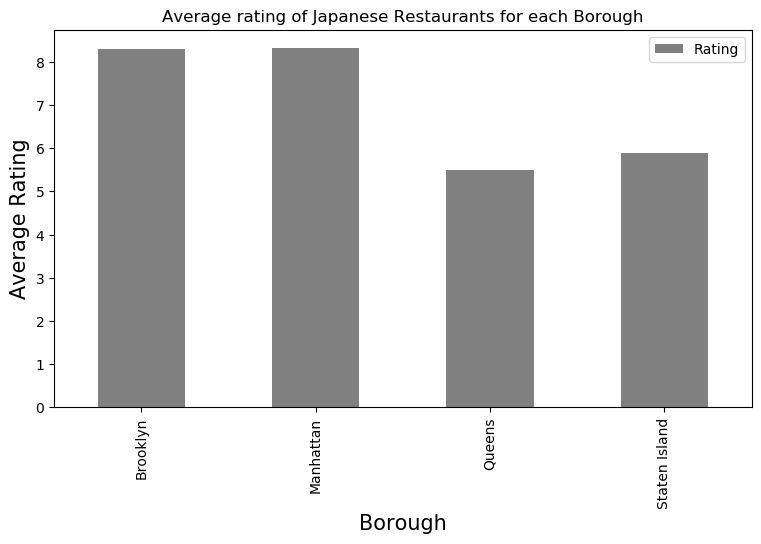

In [29]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of Japanese Restaurants for each Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
japanese_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar', color=clr)
plt.legend()
plt.show()

We can see that Brooklyn and Manhattan have restaurants with average rating > 8, followed by Queens and Staten Island (>5)

### List out the neighborhoods having restaurants with average rating > 7

In [30]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=7.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
0,Bedford Stuyvesant,8.200000
1,Boerum Hill,8.800000
2,Brooklyn Heights,8.200000
7,Cobble Hill,9.100000
8,Downtown,8.600000
9,East Village,9.200000
11,Financial District,8.300000
12,Fort Greene,8.800000
13,Fort Hamilton,8.000000
15,Grasmere,7.800000


### Merge this data with location coordinates data from New York dataset

In [31]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Brooklyn,Bedford Stuyvesant,40.687232,-73.941785,8.200000
1,Brooklyn,Boerum Hill,40.685683,-73.983748,8.800000
2,Brooklyn,Brooklyn Heights,40.695864,-73.993782,8.200000
3,Brooklyn,Cobble Hill,40.687920,-73.998561,9.100000
4,Brooklyn,Downtown,40.690844,-73.983463,8.600000
5,Manhattan,East Village,40.727847,-73.982226,9.200000
6,Manhattan,Financial District,40.707107,-74.010665,8.300000
7,Brooklyn,Fort Greene,40.688527,-73.972906,8.800000
8,Brooklyn,Fort Hamilton,40.614768,-74.031979,8.000000
9,Staten Island,Grasmere,40.598268,-74.076674,7.800000


### Let's visualize this data on map using folium and markers with borough name, restaurant name and average rating

In [ ]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=14)
# instantiate a feature group for the ratings in the dataframe
rating = folium.map.FeatureGroup()

# loop through the ratings and add each to the neighborhood feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [ ]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add ratings to map
ny_map.add_child(rating)